In [0]:
# accuracy  - точность  - процент правильного выбора класса - нужно максимизировать
# loss      - потери    - ошибка между реальными и полученными ответами - нужно минимизировать
            # - измеряет «насколько хороша» нейронная сеть в отношении данной обучающей выборки и ожидаемых ответов

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # дата генератор
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
# Набор данных кошек/собак
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


In [4]:
# Полный список директорий
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print
# cats_and_dogs_filtered/validation cats/dogs
# cats_and_dogs_filtered/train cats/dogs

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


In [0]:
# Объявим пути до нужных директорий
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [9]:
# Смотрим данные
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('Кошек в тестовом наборе данных: ', num_cats_tr)  # 1000
print('Собак в тестовом наборе данных: ', num_dogs_tr)  # 1000

print('Кошек в валидационном наборе данных: ', num_cats_val)  # 500
print('Собак в валидационном наборе данных: ', num_dogs_val)  # 500
print('--')
print('Всего изображений в тренировочном наборе данных: ', total_train)  # 2000
print('Всего изображений в валидационном наборе данных: ', total_val)  # 1000

Кошек в тестовом наборе данных:  1000
Собак в тестовом наборе данных:  1000
Кошек в валидационном наборе данных:  500
Собак в валидационном наборе данных:  500
--
Всего изображений в тренировочном наборе данных:  2000
Всего изображений в валидационном наборе данных:  1000


In [0]:
# Параметры модели
BATCH_SIZE = 100 # количество тренировочных изображений для обработки перед обновлением параметров модели  (в одной итерации НН обработало 100 изображений и после изменила веса/смещения)
IMG_SHAPE = 150 # размерность к которой будет преведено входное изображение (все изображения преобразуем к 150*150)

In [15]:
# Подготовка данных
# 1. Прочитать изображения с диска
# 2. Декодировать содержимое изображений и преобразовать в нужный формат с учетом RGB-профиля
# 3. Преобразовать к тензорам со значениями с плавающей запятой
# 4. Произвести нормализацию значений тензора из интервала от 0 до 255 к интервалу от 0 до 1, так как нейронные сети лучше работают с маленькими входными значениями.
# Это все через tf.keras.preprocessing.image.ImageDataGenerator

# генераторы
train_image_generator = ImageDataGenerator(rescale=1./255)  # rescale - преобразование каждого пикселя изображения  (нормализация)
validation_image_generator = ImageDataGenerator(rescale=1./255)

# загрзим изображения с диска, нормализуем, изменим изображения
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')  # тип меток которые возвращаются по данным (1 или 0)
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# Визуализация изображений
sample_training_images, _ = next(train_data_gen)  # next - возвращает след.блок из данных. Блок - множество изображ. + метки

# данная функция отрисует изображения в сетке размером 1х5
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

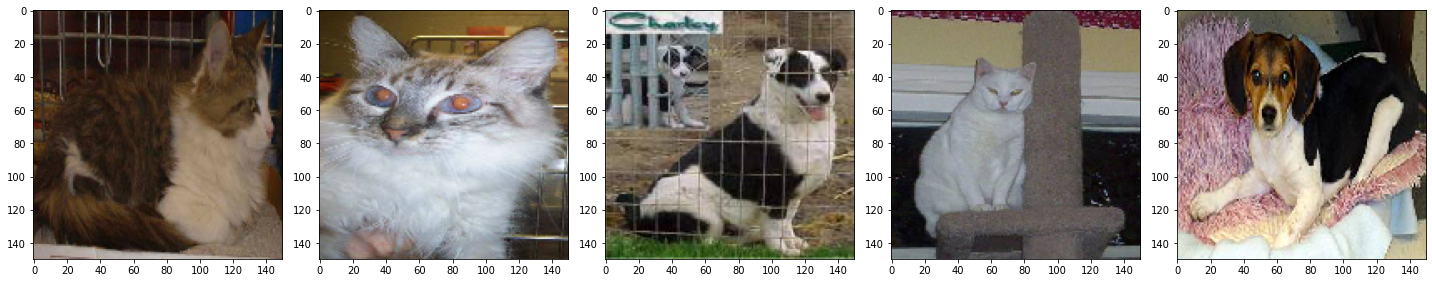

In [20]:
plotImages(sample_training_images[:5]) # отрисовываем изображения 0-4

In [0]:
# Создание модели
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [28]:
# Тренировка
EPOCHS = 100
history = model.fit_generator(  # fit_generator вместо fit т.к. используем ImageDataGenerator для блоков данных
    train_data_gen,  # сам генератор
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 16s 818ms/step - loss: 0.7098 - acc: 0.4955 - val_loss: 0.6920 - val_acc: 0.5000
Epoch 2/100
20/20 [==============================] - 9s 448ms/step - loss: 0.6921 - acc: 0.5230 - val_loss: 0.6834 - val_acc: 0.5310
Epoch 3/100
20/20 [==============================] - 9s 443ms/step - loss: 0.6935 - acc: 0.5275 - val_loss: 0.6752 - val_acc: 0.6230
Epoch 4/100
20/20 [==============================] - 9s 444ms/step - loss: 0.6762 - acc: 0.5810 - val_loss: 0.6444 - val_acc: 0.6130
Epoch 5/100
20/20 [==============================] - 9s 442ms/step - loss: 0.6340 - acc: 0.6405 - val_loss: 0.6019 - val_acc: 0.6620
Epoch 6/100
20/20 [==============================] - 9s 452ms/step - loss: 0.5761 - acc: 0.7040 - val_loss: 0.7088 - val_acc: 0.5820
Epoch 7/100
20/20 [==============================] - 9s 453ms/step - loss: 0.5848 - acc: 0.6900 - val_loss: 0.5980 - val_acc: 0.6680
Epoch 8/100
20/20 [==============================] - 9s 444ms/step -

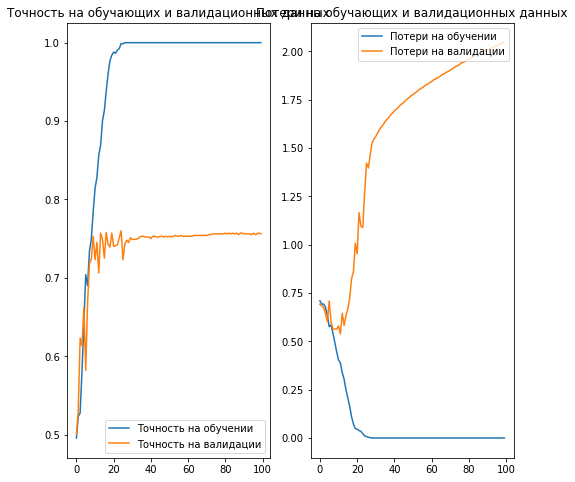

In [30]:
# Визуализация
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность на обучающих и валидационных данных')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающих и валидационных данных')
plt.savefig('./foo.png')
plt.show()